In [1]:
using ScikitLearn
using Statistics
using Plots
using Random

@sk_import datasets: (make_circles, make_moons, make_blobs)

PyObject <function make_blobs at 0x117c829d8>

In [2]:
n_samples = 1000
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)

([8.62219 1.9358; -4.73671 -7.97096; … ; -5.47915 -10.537; 6.12056 0.968963], [1, 2, 1, 1, 1, 2, 1, 2, 1, 1  …  0, 0, 0, 2, 0, 1, 2, 2, 2, 1])

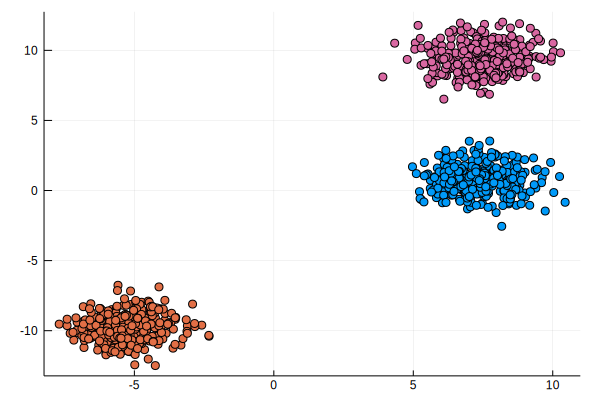

In [3]:
bl_points, bl_label = blobs
plt = scatter(bl_points[:, 1], bl_points[:, 2], label="", mc=bl_label)

In [8]:
mutable struct KMean
    points::Array{Float64}
    K::Int64
    dim::Int64
    zs::Vector{Int64}
    μs::Array{Float64}
end

function KMean(points::Array{Float64}, K::Int64)
    n_points = size(points, 1)
    zs = rand(1:K, n_points)
    dim = size(points, 2)
    kmean = KMean(points, K, dim, zs, zeros(1, dim, K))
    update_μs!(kmean)
    kmean
end

function update_μs!(km::KMean)
    km.μs = cat([mean(km.points[km.zs .== i, :], dims=1) for i in 1:km.K]..., dims=3)
    km
end

function update_zs!(km::KMean)
    norms = sum((km.points .- km.μs).^2, dims=2)
    argmin_norms = [x[3] for x in argmin(norms, dims=3)][:]
    
    existing_labels = Set(argmin_norms)
    missing_labels = setdiff(1:km.K, existing_labels)
    n_missings = Base.length(missing_labels)
    if n_missings != 0
        first_idx = [findfirst(isequal(x), argmin_norms) for x in existing_labels]
        n_points = size(km.points, 1)
        idx_choice = setdiff(1:n_points, first_idx)
        choice = shuffle(idx_choice)[1:n_missings]
        argmin_norms[choice] = vec(missing_labels)
    end
    
    km.zs = argmin_norms
    km
end

function update!(km::KMean)
    update_zs!(km)
    update_μs!(km)
    km
end

KMean

In [25]:
km = KMean(bl_points, 3)

anim = @animate for i=1:20
    scatter(km.points[:, 1], km.points[:, 2], mc=km.zs, label="")
    plt = scatter!(km.μs[1, 1, :], km.μs[1, 2, :], ms=8, mc=:yellow, msw=3, label="")
    update!(km)
    plt
end

gif(anim, "tmp.gif", fps = 1)

┌ Info: Saved animation to 
│   fn = /Users/apple/Documents/notebook_blog/tmp.gif
└ @ Plots /Users/apple/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/apple/Documents/notebook_blog/tmp.gif")